## FCF Buhguul Multi factor kmeans clustering algo backtest OOS comparison

In [1]:
import numpy as np
import pandas as pd
import pyfolio as pf
import seaborn as sns
import alphalens as al
import empyrical as ep
import matplotlib.pyplot as plt
from quantopian.pipeline.data import EquityPricing
from quantopian.research.experimental import get_factor_returns, get_factor_loadings

In [2]:
#bt = get_backtest('5d6574870b20fb60a0feea87')#2010-2017
#bt = get_backtest('5d657db906688560ea8bbb89')#2014-2018
bt = get_backtest('5d6bf04d6b6c99635a8a871f')#2017-2019

100% Time:  0:00:05|##########################################################|


In [9]:
results = bt.pyfolio_positions.drop('cash', axis=1)
results.columns = results.columns.str.split('-').to_series().apply(lambda x: int(x[1]))
results = results.div(results.abs().sum(axis=1), axis=0)
results = results.stack().dropna()

In [26]:
start = results.index.levels[0][0]
#end = results.index.levels[0][-1] + pd.Timedelta(days=30)
end = results.index.levels[0][-39] + pd.Timedelta(days=30)#2017-2019

end_to_today = end - pd.Timestamp.today(tz='UTC')
# If date goes into the future, cut it
if end_to_today.days > 2:
    end = pd.Timestamp.today(tz='UTC') - pd.offsets.BDay() * 2
    end = end.normalize()

In [27]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="close_price")
stock_rets = pricing.pct_change()

# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))
# Fix a bug in the risk returns
factor_returns.loc[factor_returns.value.idxmax(), 'value'] = 0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    import empyrical as ep
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def compute_turnover(df):
    return df.dropna().unstack().dropna(how='all').fillna(0).diff().abs().sum(1)

def get_max_median_position_concentration(expos):
    longs = expos.loc[expos > 0]
    shorts = expos.loc[expos < 0]

    return expos.groupby(level=0).quantile([.05, .25, .5, .75, .95]).unstack()

def compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=range(1, 22), view=None):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False,
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                                factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                                factor_returns, factor_loadings)
    
    if view is None:
        perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
    else:
        perf_attrib = view.map_sync(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    turnover = compute_turnover(factor)
    n_holdings = factor.groupby(level=0).count()
    perc_holdings = get_max_median_position_concentration(factor)
    
    return {'factor_data_total': factor_data_total, 
            'portfolio_returns_total': portfolio_returns_total,
            'portfolio_returns_specific': portfolio_returns_specific,
            'risk_exposures_portfolio': risk_exposures_portfolio,
            'perf_attribution': perf_attribution,
            'delay_sharpes_total': delay_sharpes_total,
            'delay_sharpes_specific': delay_sharpes_specific,
            'turnover': turnover,
            'n_holdings': n_holdings,
            'perc_holdings': perc_holdings,
    }

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings, periods=range(1, 22), view=None):
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(5, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])
    
    factor_stats = compute_factor_stats(factor, pricing, factor_returns, factor_loadings, periods=periods, view=view)
                         
    pd.DataFrame({'specific': factor_stats['delay_sharpes_specific'], 
                  'total': factor_stats['delay_sharpes_total']}).plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = factor_stats['portfolio_returns_total'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = factor_stats['portfolio_returns_specific'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(factor_stats['risk_exposures_portfolio'].reindex(columns=factor_stats['perf_attribution'].columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(factor_stats['perf_attribution']).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    factor_stats['perf_attribution'].apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    ax6 = plt.subplot(gs[-1, 0:2])
    factor_stats['n_holdings'].plot(color='b', ax=ax6)
    ax6.set_ylabel('# holdings', color='b')
    ax6.tick_params(axis='y', labelcolor='b')
    
    ax62 = ax6.twinx()
    factor_stats['turnover'].plot(color='r', ax=ax62)
    ax62.set_ylabel('turnover', color='r')
    ax62.tick_params(axis='y', labelcolor='r')
    
    ax7 = plt.subplot(gs[-1, 2:4])
    factor_stats['perc_holdings'].plot(ax=ax7)
    ax7.set(ylabel='Long/short perc holdings')
    
    gs.tight_layout(fig)
    
    return fig, factor_stats

In [7]:
backtest_names = {
    
'2010-2017' : '5d6574870b20fb60a0feea87',
'2014-2018' : '5d657db906688560ea8bbb89',
'2017-2019' : '5d6bf04d6b6c99635a8a871f',

}

backtests = {}
for b in backtest_names:
    backtests[b] = get_backtest(backtest_names[b])
    backtests[b].cumulative_performance.ending_portfolio_value

100% Time:  0:00:05|##########################################################|
100% Time:  0:00:18|##########################################################|
100% Time:  0:00:09|##########################################################|


In [8]:
top_two_backtests = {
    '2010-2017': backtests['2010-2017'],
    '2014-2018': backtests['2014-2018'],
    '2017-2019': backtests['2017-2019']
}

In [9]:
def create_dict_with_backtest(backtest_dict, calc_type):
    """
    Returns a dictionary that contains the specified metric from the backtest
    """
    plot_dict = {}
    for title, backtest in backtest_dict.iteritems():
        if calc_type == 'drawdowns':
            calc = backtest.risk.max_drawdown.iloc[-1]
        elif calc_type == 'total_returns': 
            calc = backtest.cumulative_performance.returns[-1]*100
        elif calc_type == 'sharpe_ratios':
            calc = backtest.risk.sharpe[-1]
        elif calc_type == 'annual_returns':
            calc = annual_return(backtest.cumulative_performance.ending_portfolio_value)
        elif calc_type == 'annual_volatility':
            calc = annual_volatility(backtest.cumulative_performance.ending_portfolio_value)
        elif calc_type == 'calmar_ratios':
            calc = calmar_ratio(backtest.cumulative_performance.ending_portfolio_value)
        elif calc_type == 'stability_of_ts':
            calc = stability_of_time_series(backtest.cumulative_performance.ending_portfolio_value)
        plot_dict[title] = calc
    return plot_dict

def create_labels_and_y_pos(plot_dict):
    """
    Returns labels and y_pos for the plot
    """
    labels = sorted(plot_dict.keys(), key=lambda x: plot_dict[x])
    y_pos = np.arange(len(labels))
    return labels, y_pos

def create_plot(plot_dict, y_pos, labels, color, xlabel, title, subplot_pos, subplot_len):
    """
    Creates a bar plot
    """
    ax = fig.add_subplot(subplot_len, 1, subplot_pos)
    ax.grid(b=False)
    ax.barh(y_pos, plot_dict, align='center', alpha=0.6, color=color)
    plt.yticks(y_pos, labels)
    plt.title(title)
    
    for idx, num in enumerate(plot_dict):
        plt.annotate("%0.2f" % num, xy=(num, idx), va='center')

def annual_return(ts, input_is_nav=True, style='calendar'):
   
    if ts.size < 1:
        return np.nan
    
    if input_is_nav:
        temp_returns = ts.pct_change().dropna()
        if style == 'calendar':
            num_years = len(temp_returns) / 252
            start_value = ts[0]
            end_value = ts[-1]
            return ((end_value - start_value)/start_value) / num_years
        if style == 'compound':
            return pow( (1 + temp_returns.mean()), 252 ) - 1
        else:
            return temp_returns.mean() * 252
    else:
        if style == 'calendar':
            num_years = len(ts) / 252
            temp_nav = cum_returns(ts, with_starting_value=100)
            start_value = temp_nav[0]
            end_value = temp_nav[-1]
            return ((end_value - start_value)/start_value) / num_years
        if style == 'compound':
            return pow( (1 + ts.mean()), 252 ) - 1
        else:
            return ts.mean() * 252


def annual_volatility(ts, input_is_nav=True):
    if ts.size < 2:
        return np.nan
    if input_is_nav:
        temp_returns = ts.pct_change().dropna()
        return temp_returns.std() * np.sqrt(252)
    else:
        return ts.std() * np.sqrt(252)


def calmar_ratio(ts, input_is_nav=True):
    temp_max_dd = max_drawdown(ts=ts)
    if temp_max_dd < 0:
        if input_is_nav:
            temp = annual_return(ts=ts, input_is_nav=input_is_nav) / abs(max_drawdown(ts=ts))
        else:
            temp_nav = cum_returns(ts,with_starting_value=100)
            temp = annual_return(ts=ts, input_is_nav=input_is_nav) / abs(max_drawdown(ts=temp_nav))
    else:
        return np.nan
    
    if np.isinf(temp):
        return np.nan
    else:
        return temp

def stability_of_time_series(ts, log_value=True ):
    if ts.size < 2:
        return np.nan
    
    ts_len = ts.size
    X = range(0, ts_len)
    X = sm.add_constant(X)
    if log_value:
        temp_values = np.log10(ts.values)
    else:
        temp_values = ts.values
    model = sm.OLS(temp_values, X).fit()
    
    return model.rsquared

def normalize(df, with_starting_value=1):
    if with_starting_value > 1:
        return with_starting_value * ( df / df.iloc[0] )
    else:
        return df / df.iloc[0]

def cum_returns(df, with_starting_value=None):
    if with_starting_value is None:
        return (1 + df).cumprod() - 1
    else:
        return (1 + df).cumprod() * with_starting_value
    
def max_drawdown(ts):
    MDD = 0
    DD = 0
    peak = -99999
    for value in ts:
        if (value > peak):
            peak = value
        else:
            DD = (peak - value) / peak
        if (DD > MDD):
            MDD = DD
    return -1*MDD

In [10]:
drawdowns = create_dict_with_backtest(top_two_backtests, 'drawdowns')
drawdown_labels, drawdown_y_pos = create_labels_and_y_pos(drawdowns)
drawdowns = [drawdowns[s] for s in drawdown_labels]

total_returns = create_dict_with_backtest(top_two_backtests, 'total_returns')
return_labels, return_y_pos = create_labels_and_y_pos(total_returns)
total_returns = [total_returns[s] for s in return_labels]
    
sharpe_ratios = create_dict_with_backtest(top_two_backtests, 'sharpe_ratios')
labels, y_pos = create_labels_and_y_pos(sharpe_ratios)
sharpe_ratios = [sharpe_ratios[s] for s in labels]

calmar_ratios = create_dict_with_backtest(top_two_backtests, 'calmar_ratios')
calmar_labels, calmar_y_pos = create_labels_and_y_pos(calmar_ratios)
calmar_ratios = [calmar_ratios[s] for s in calmar_labels]

annual_returns = create_dict_with_backtest(top_two_backtests, 'annual_returns')
annual_labels, annual_y_pos = create_labels_and_y_pos(annual_returns)
annual_returns = [annual_returns[s] for s in annual_labels]

annual_volatility = create_dict_with_backtest(top_two_backtests, 'annual_volatility')
vol_labels, vol_y_pos = create_labels_and_y_pos(annual_volatility)
annual_volatility = [annual_volatility[s] for s in vol_labels]

In [11]:
_10_17_bt = get_backtest('5d6574870b20fb60a0feea87')#2010-2017
_10_17_bt_returns = _10_17_bt.daily_performance.returns
_10_17_bt_stats = pf.timeseries.perf_stats(_10_17_bt_returns)
_10_17_bt_stats = _10_17_bt_stats.rename(columns={'perf_stats':'FCF Buhguul 2010-2017 (backtest)'})

_14_18_bt =get_backtest('5d657db906688560ea8bbb89')#2014-2018
_14_18_bt_returns = _14_18_bt.daily_performance.returns
_14_18_bt_stats = pf.timeseries.perf_stats(_14_18_bt_returns)
_14_18_bt_stats = _14_18_bt_stats.rename(columns={'perf_stats':'FCF Buhguul 2014-2018 (backtest)'})

_17_19_bt = get_backtest('5d6bf04d6b6c99635a8a871f')#2017-2019
_17_19_bt_returns = _17_19_bt.daily_performance.returns
_17_19_bt_stats = pf.timeseries.perf_stats(_17_19_bt_returns)
_17_19_bt_stats = _17_19_bt_stats.rename(columns={'perf_stats':'FCF Buhguul 2017-2019 (backtest)'})

100% Time:  0:00:18|##########################################################|
100% Time:  0:00:10|##########################################################|
100% Time:  0:00:06|##########################################################|


In [12]:
#performance statistics
perf_stats = [_10_17_bt_stats,_14_18_bt_stats,_17_19_bt_stats]
perf_stats = pd.concat(perf_stats,axis=1)
perf_stats.columns = ['2010_2017_bt','2014_2018_bt','2017_2019_bt']

std1 = _10_17_bt_returns.rolling(63).std()
std2 = _14_18_bt_returns.rolling(63).std()
std3 = _17_19_bt_returns.rolling(63).std()

mean1 = _10_17_bt_returns.rolling(63).mean()
mean2 = _14_18_bt_returns.rolling(63).mean()
mean3 = _17_19_bt_returns.rolling(63).mean()

i90_des = _10_17_bt_returns.describe()
i90_des = pd.DataFrame(i90_des)

vol2yr_des = _14_18_bt_returns.describe()
vol2yr_des = pd.DataFrame(vol2yr_des)
vol2yr_des['14_18_bt_returns'] = i90_des

vol2yr_des1 = _17_19_bt_returns.describe()
vol2yr_des1 = pd.DataFrame(vol2yr_des1)
vol2yr_des['17_19_bt_returns'] = vol2yr_des1

vol2yr_des.columns = ['10_17_returns','14_18_returns','17_19_returns']

_10_17_df = pd.DataFrame(_10_17_bt_returns)
_17_19_df = pd.DataFrame(_17_19_bt_returns)

_17_19df = _17_19_df.loc['2017-12-25':'2019-08-28']

frames = [_10_17_df, _17_19df]

res0 = pd.concat(frames)

res1 = res0.cumsum()
res2 = res1.loc['2017-08-25':'2019-08-28']
res3 = res1.loc['2010-01-01':'2014-01-01']
res4 = res1.loc['2014-01-01':'2017-08-24']

In [13]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 0.001) / n
    return(x,y)

#2010-2017

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


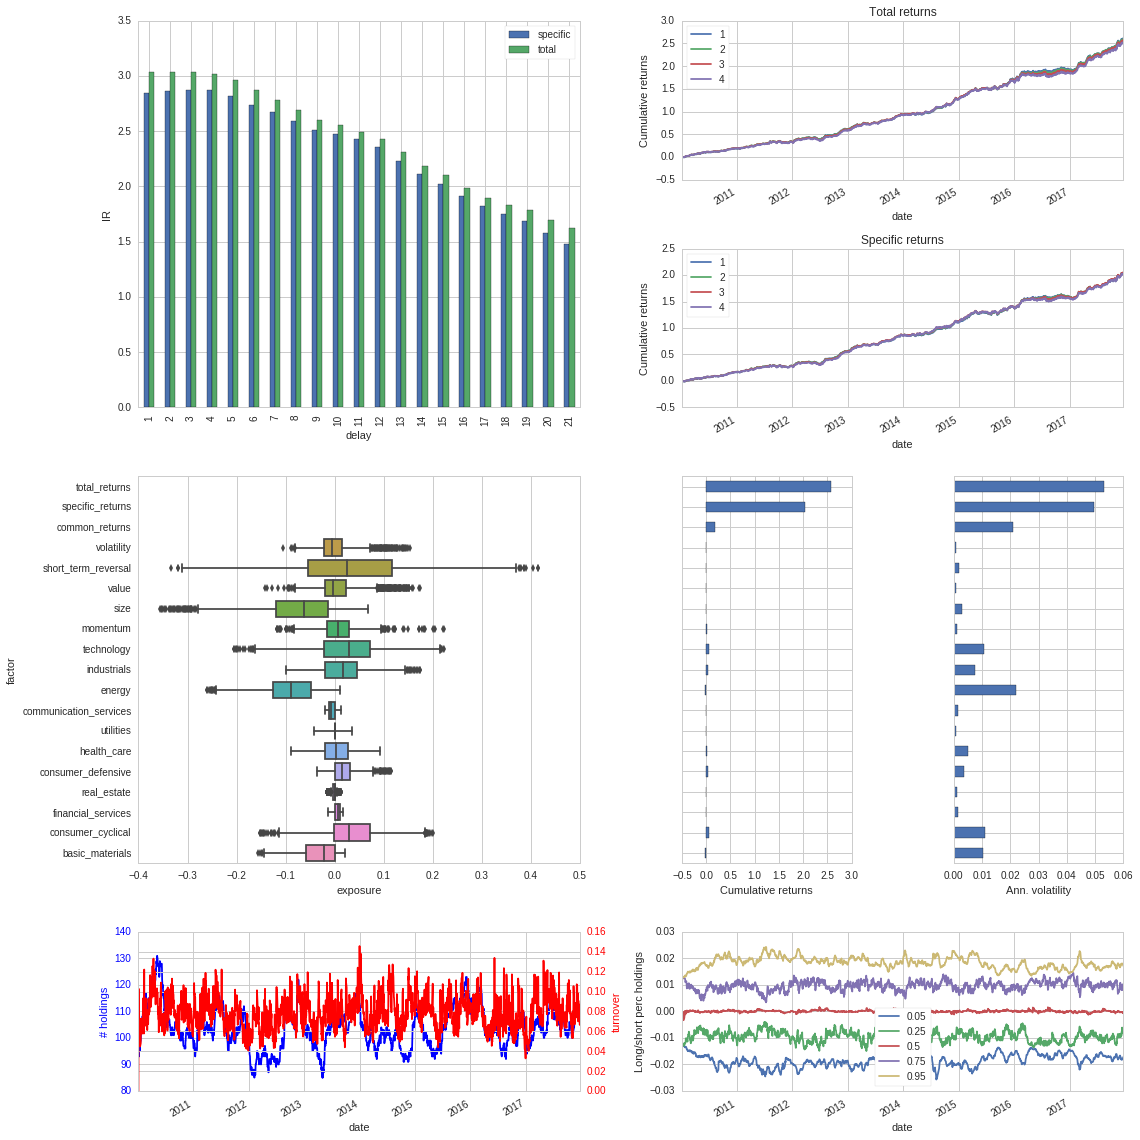

In [10]:
_, factor_stats = plot_overview_tear_sheet(results, 
                         pricing, 
                         factor_returns, 
                         factor_loadings);

In [13]:
df = pd.DataFrame(factor_stats['turnover'].describe())
df.columns = ['turnover']
df['# of holdings'] = factor_stats['n_holdings'].describe()
df['delay_sharpes_total'] = factor_stats['delay_sharpes_total'].describe()
df['delay_sharpes_specific'] = factor_stats['delay_sharpes_specific'].describe()
df

,turnover,# of holdings,delay_sharpes_total,delay_sharpes_specific
count,2009.000000,2009.000000,21.000000,21.000000
mean,0.078057,103.766053,2.425770,2.315514
std,0.017044,7.907648,0.489244,0.470199
min,0.000000,85.000000,1.625917,1.478210
25%,0.066238,98.000000,1.983931,1.909713
50%,0.076450,103.000000,2.495291,2.425708
75%,0.088131,108.000000,2.872534,2.732788
max,0.145796,131.000000,3.040089,2.876558


#### 1. Backtest (2010-2017): 
#####- Good factor delay almost perfectly consistent over 4 days lag 
#####- Total returns above 250% and good specific returns above 200%
#####- First Lag seems to be the strongest 
#####- Mean Risk factor exposures close to 0 
#####- Most volatile risk factor exposures are short term reversal and size

#2014-2018

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


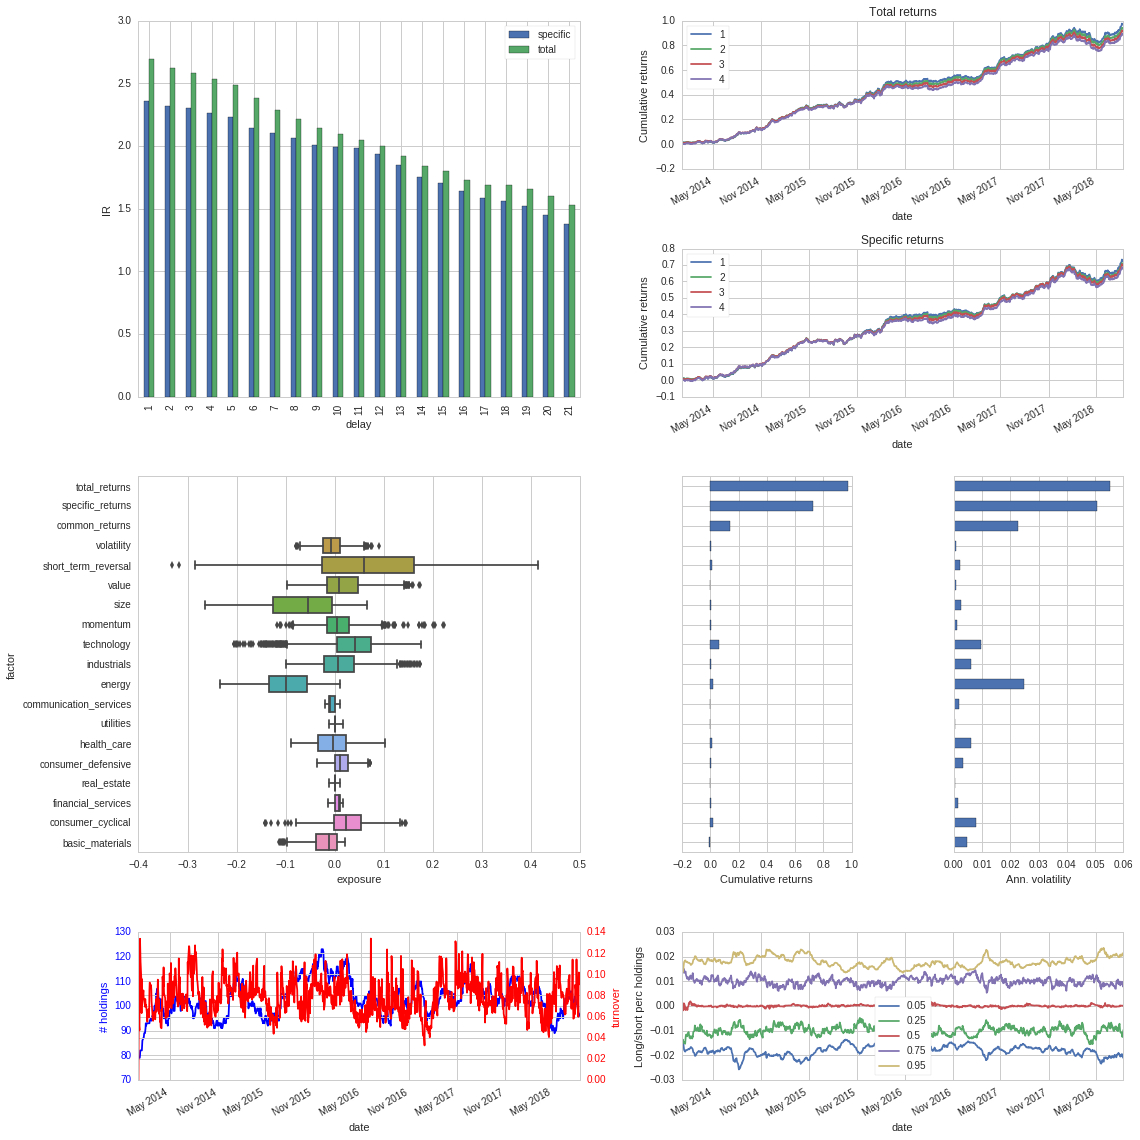

In [7]:
_, factor_stats = plot_overview_tear_sheet(results, 
                         pricing, 
                         factor_returns, 
                         factor_loadings);

In [8]:
df = pd.DataFrame(factor_stats['turnover'].describe())
df.columns = ['turnover']
df['# of holdings'] = factor_stats['n_holdings'].describe()
df['delay_sharpes_total'] = factor_stats['delay_sharpes_total'].describe()
df['delay_sharpes_specific'] = factor_stats['delay_sharpes_specific'].describe()
df

,turnover,# of holdings,delay_sharpes_total,delay_sharpes_specific
count,1163.000000,1163.000000,21.000000,21.000000
mean,0.078513,102.924334,2.072964,1.912304
std,0.017525,7.189789,0.371700,0.308722
min,0.000000,79.000000,1.528515,1.378718
25%,0.066173,98.000000,1.731677,1.638107
50%,0.076784,103.000000,2.044174,1.987520
75%,0.089083,108.000000,2.380354,2.144119
max,0.133756,123.000000,2.693263,2.362002


#### 2. Backtest (2014-2018): 
#####- First delay is the strongest but immediately starts to decay after the first lag
#####- Total Returns around 100% and specific around 75%
#####- Mean Risk factor exposures close to 0 
#####- Most volatile risk factor exposures are short term reversal and size

### Backtest (2010-2017) & (2014-2018) Comparison: 
Strength of the factor delay between the 2 backtests weakend but the first lag being the strongest was consistent. There was also less strength in the specicfic returns proportion to the total returns. Daily turnover and average holdings decreased. Mean risk factor exposures and volatility stayed consistent.

#2017-2019

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


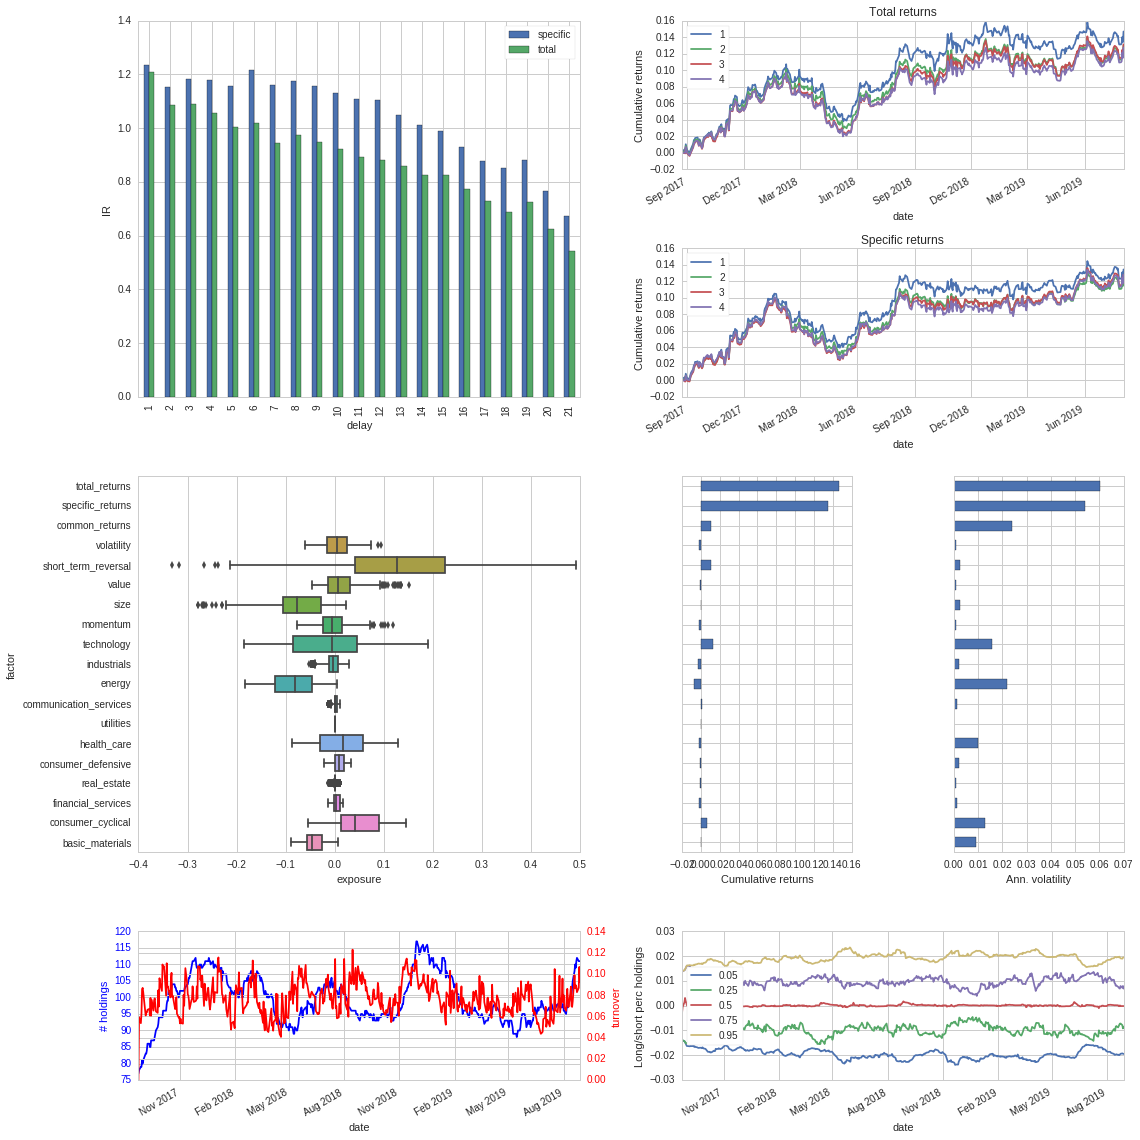

In [29]:
_, factor_stats = plot_overview_tear_sheet(results, 
                         pricing, 
                         factor_returns, 
                         factor_loadings);

In [30]:
df = pd.DataFrame(factor_stats['turnover'].describe())
df.columns = ['turnover']
df['# of holdings'] = factor_stats['n_holdings'].describe()
df['delay_sharpes_total'] = factor_stats['delay_sharpes_total'].describe()
df['delay_sharpes_specific'] = factor_stats['delay_sharpes_specific'].describe()
df

,turnover,# of holdings,delay_sharpes_total,delay_sharpes_specific
count,506.000000,506.000000,21.000000,21.000000
mean,0.077127,99.312253,0.886750,1.046996
std,0.015999,7.224911,0.167016,0.159645
min,0.000000,77.000000,0.543176,0.673374
25%,0.066008,94.000000,0.772240,0.928445
50%,0.076283,98.000000,0.892615,1.109866
75%,0.087959,104.000000,1.003736,1.159321
max,0.122832,117.000000,1.209271,1.233779


#### 3. Backtest (2017-2019):
#####- First delay is the strongest but immediately starts to decay after the first lag
#####- Total returns above 15% and good specific returns above 14%
#####- Mean Risk factor exposures close to 0 except short term reversal
#####- Most volatile risk factor exposures are size and short term reversal (very extreme)

### Backtest (2010-2017), (2014-2018) & (2017-2019) Comparison: 
The strength of the factor delay between the backtests weakend but the first lag being the strongest was consistent through them all. There was also less strength in the specicfic returns/IR proportion to the total returns/IR from 2010-2017 then the OOS specific from 2018-2019 was stronger than the total returns/IR. Daily turnover and average holdings decreased throught all backtest. Mean risk factor exposures and volatility stayed mostly consistent close to 0 and short term reversal became extremely volatile OOS.

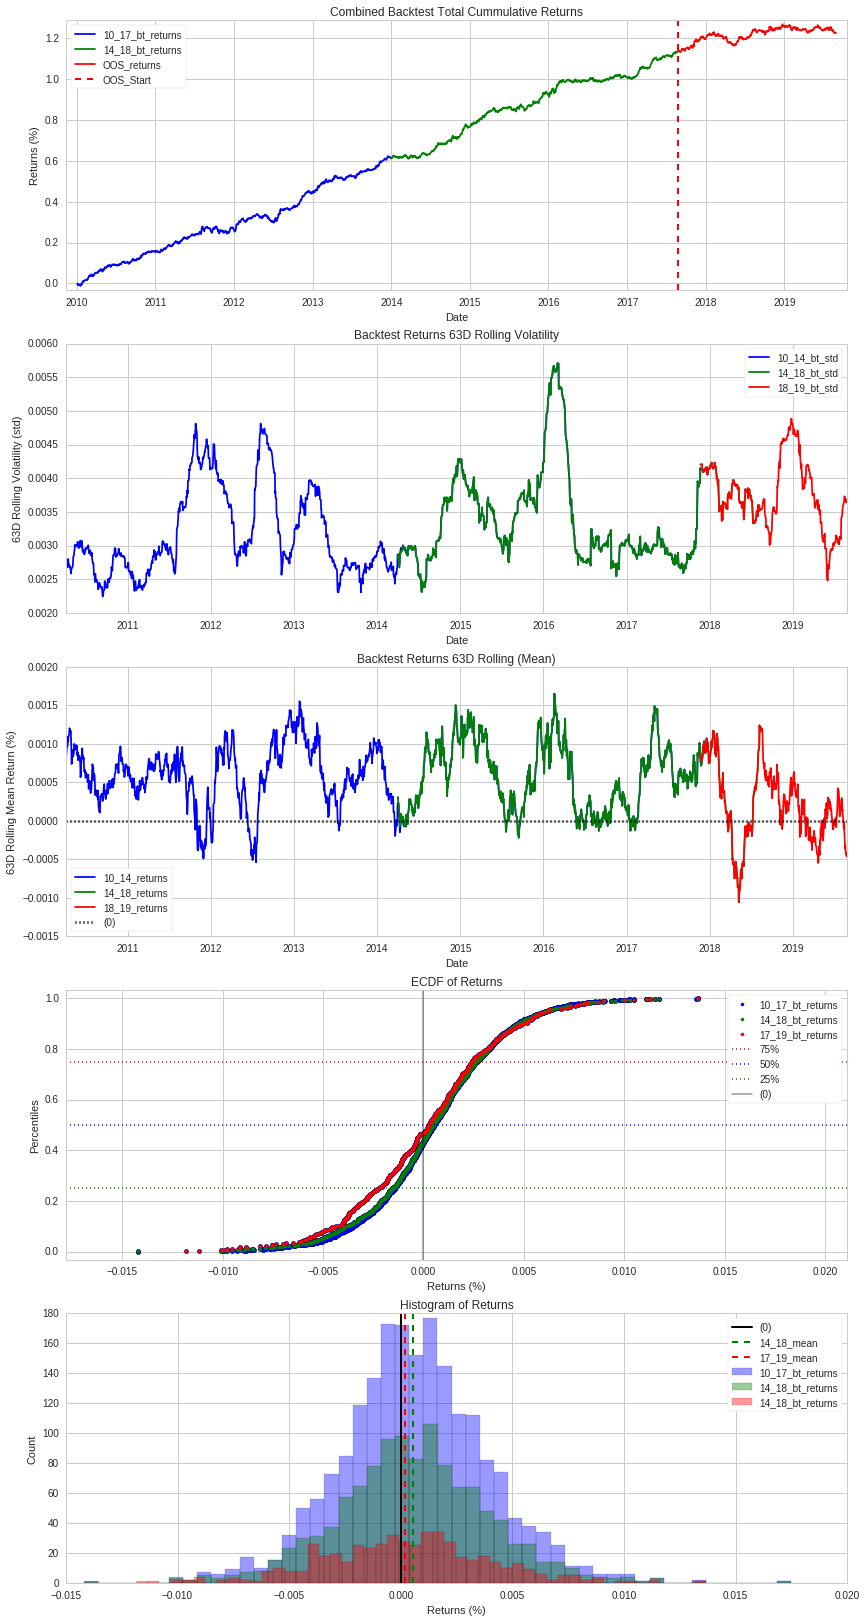

,2010_2017_bt,2014_2018_bt,2017_2019_bt
Annual return,0.161276,0.145163,0.047659
Cumulative returns,2.293679,0.869293,0.097995
Annual volatility,0.052977,0.055197,0.059969
Sharpe ratio,2.849629,2.483911,0.806365
Calmar ratio,3.863280,2.233981,0.734247
Stability,0.994481,0.973249,0.651251
Max drawdown,-0.041746,-0.064980,-0.064908
Omega ratio,1.597369,1.507811,1.139255
Sortino ratio,4.710517,4.003524,1.184490
Skew,0.097549,0.074957,-0.004274


In [12]:
plt.figure(figsize=(14, 28))

plt.subplot(512)
plt.plot(std1, label = '10_14_bt_std', color = 'blue')
plt.plot(std2, label = '14_18_bt_std', color = 'green')
plt.plot(std3, label = '18_19_bt_std', color = 'red')
plt.title('Backtest Returns 63D Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('63D Rolling Volatility (std)')
plt.legend();

plt.subplot(513)
plt.plot(mean1, label = '10_14_returns', color = 'blue')
plt.plot(mean2, label = '14_18_returns', color = 'green')
plt.plot(mean3, label = '18_19_returns', color = 'red')
plt.axhline(color='black', linestyle=':', linewidth=3, label = '(0)')
plt.title('Backtest Returns 63D Rolling (Mean)')
plt.xlabel('Date')
plt.ylabel('63D Rolling Mean Return (%)')
plt.legend(loc='lower left');

plt.subplot(514)
x,y = ecdf(_10_17_bt_returns)
plt.scatter(x=x, y=y)
plt.plot(x,y, color = 'blue', label = '10_17_bt_returns', marker='.', linestyle='none')

x,y = ecdf(_14_18_bt_returns)
plt.scatter(x=x, y=y)
plt.plot(x,y, color = 'green', label = '14_18_bt_returns', marker='.', linestyle='none')

x,y = ecdf(_17_19_bt_returns)
plt.scatter(x=x, y=y)
plt.plot(x,y, color = 'red', label = '17_19_bt_returns', marker='.', linestyle='none')

plt.axhline(y=0.75, color='red', linewidth=1.5, linestyle=':',label = '75%')
plt.axhline(y=0.5, color='blue', linewidth=1.5, linestyle=':',label = '50%')
plt.axhline(y=0.25, color='green', linewidth=1.5, linestyle=':',label = '25%')
plt.axvline(x=0, color='black', linewidth=1.5, label = '(0)', alpha = 0.4)


plt.margins(0.02)
plt.xlabel('Returns (%)')
plt.ylabel('Percentiles')
plt.title('ECDF of Returns')
plt.legend()

plt.subplot(515)
_ = plt.hist(_10_17_bt_returns, color = 'blue',alpha = 0.4,label = '10_17_bt_returns', bins=50)
_ = plt.axvline(x=0, color='black', linewidth=2, linestyle='-',label = '(0)')
_ = plt.hist(_14_18_bt_returns, color = 'green',alpha = 0.4,label = '14_18_bt_returns', bins=50)
_ = plt.axvline(_14_18_bt_returns.mean(), color='green', linewidth=2, linestyle='dashed',label = '14_18_mean')
_ = plt.hist(_17_19_bt_returns, color = 'red',alpha = 0.4,label = '14_18_bt_returns', bins=50)
_ = plt.axvline(_17_19_bt_returns.mean(), color='red', linewidth=2, linestyle='dashed',label = '17_19_mean')

plt.xlabel('Returns (%)')
plt.ylabel('Count')
plt.title('Histogram of Returns')
plt.legend()

plt.subplot(511)
plt.plot(res3,label = '10_17_bt_returns', color='blue')
plt.plot(res4,label = '14_18_bt_returns', color='green')
plt.plot(res2,label = 'OOS_returns', color='red')
plt.axvline(x='2017-08-25', color='red', linewidth=2, linestyle='dashed', label='OOS_Start')

plt.margins(0.015)
plt.title('Combined Backtest Total Cummulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend(loc='upper left');

plt.show();

perf_stats



	 10_17_bt 			 14_18_bt 			 17_19_bt


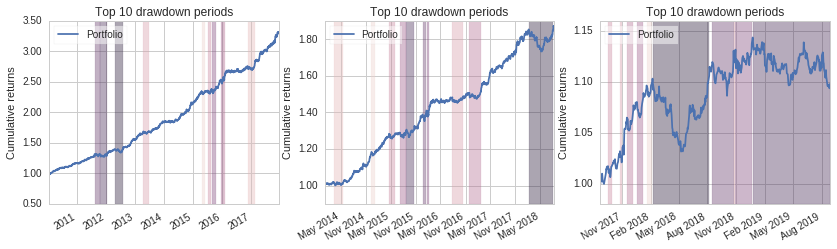

,Cumulative returns
2010_2017_bt,2.293679
2014_2018_bt,0.869293
2017_2019_bt,0.097995


In [6]:
#################################################
#
#  Show Top 5 Drawdown Periods
#
#################################################
#print(perf_stats)

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_drawdown_periods(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_drawdown_periods(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_drawdown_periods(_17_19_bt_returns,ax=ax3)

plt.show();

pd.DataFrame(perf_stats.loc['Cumulative returns'])



	 10_17_bt 			 14_18_bt 			 17_19_bt


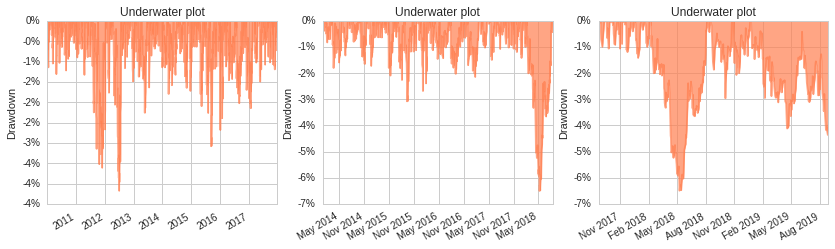

,Max drawdown
2010_2017_bt,-0.041746
2014_2018_bt,-0.064980
2017_2019_bt,-0.064908


In [7]:
#################################################
#
#  Show Underwater Plot
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_drawdown_underwater(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_drawdown_underwater(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_drawdown_underwater(_17_19_bt_returns,ax=ax3)

plt.show();

pd.DataFrame(perf_stats.loc['Max drawdown'])



	 10_17_bt 			 14_18_bt 			 17_19_bt


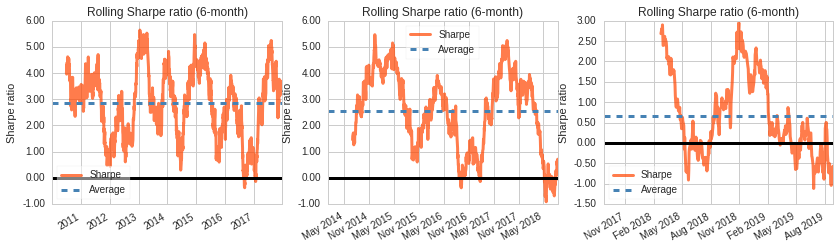

,Sharpe ratio
2010_2017_bt,2.849629
2014_2018_bt,2.483911
2017_2019_bt,0.806365


In [8]:
#################################################
#
#  Show Rolling Sharpe Ratio
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_rolling_sharpe(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_rolling_sharpe(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_rolling_sharpe(_17_19_bt_returns,ax=ax3)

plt.show();

pd.DataFrame(perf_stats.loc['Sharpe ratio'])



	 10_17_bt 			 14_18_bt 			 17_19_bt


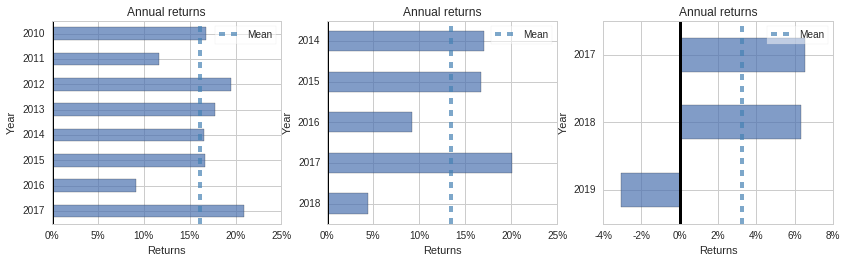

,Annual return
2010_2017_bt,0.161276
2014_2018_bt,0.145163
2017_2019_bt,0.047659


In [9]:
#################################################
#
#  Show Annual Returns
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_annual_returns(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_annual_returns(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_annual_returns(_17_19_bt_returns,ax=ax3)

plt.show();

pd.DataFrame(perf_stats.loc['Annual return'])



	 10_17_bt 			 14_18_bt 			 17_19_bt


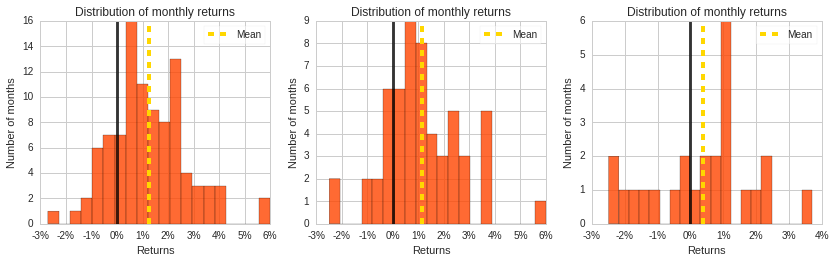

,Skew,Kurtosis
2010_2017_bt,0.097549,0.932319
2014_2018_bt,0.074957,1.125025
2017_2019_bt,-0.004274,0.502362


In [10]:
#################################################
#
#  Show Distribution Monthly Returns
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_monthly_returns_dist(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_monthly_returns_dist(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_monthly_returns_dist(_17_19_bt_returns,ax=ax3)

plt.show();

x = pd.DataFrame(perf_stats.loc['Skew'])
x['Kurtosis'] = perf_stats.loc['Kurtosis']
x



	 10_17_bt 			 14_18_bt 			 17_19_bt


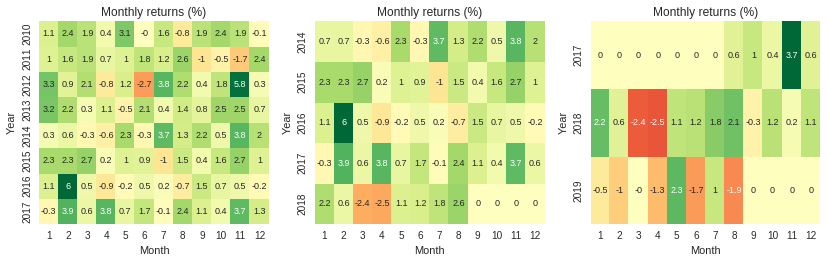

In [11]:
#################################################
#
#  Show Monthly Returns Heat Map
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plotting.plot_monthly_returns_heatmap(_10_17_bt_returns,ax=ax1)
pf.plotting.plot_monthly_returns_heatmap(_14_18_bt_returns,ax=ax2)
pf.plotting.plot_monthly_returns_heatmap(_17_19_bt_returns,ax=ax3)

plt.show();



	 10_17_bt 			 14_18_bt 			 17_19_bt


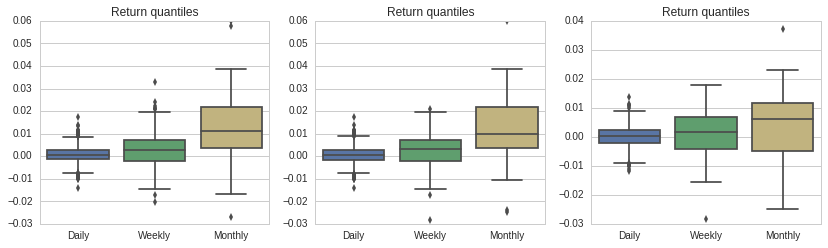

,10_17_returns,14_18_returns,17_19_returns
count,1163.000000,2009.000000,506.000000
mean,0.000544,0.000599,0.000192
std,0.003477,0.003337,0.003778
min,-0.014189,-0.014188,-0.011830
25%,-0.001546,-0.001431,-0.002221
50%,0.000497,0.000518,0.000282
75%,0.002634,0.002642,0.002421
max,0.017482,0.017479,0.013677


In [12]:
#################################################
#
#  Show Returns Box Plot
#
#################################################

ax1 = plt.subplot2grid((2,3), (0,0) )
ax2 = plt.subplot2grid((2,3), (0,1) )
ax3 = plt.subplot2grid((2,3), (0,2) )

print '\n\n\t 10_17_bt \t\t\t 14_18_bt \t\t\t 17_19_bt'

pf.plot_return_quantiles(_10_17_bt_returns,ax=ax1)
pf.plot_return_quantiles(_14_18_bt_returns,ax=ax2)
pf.plot_return_quantiles(_17_19_bt_returns,ax=ax3)

plt.show();

vol2yr_des

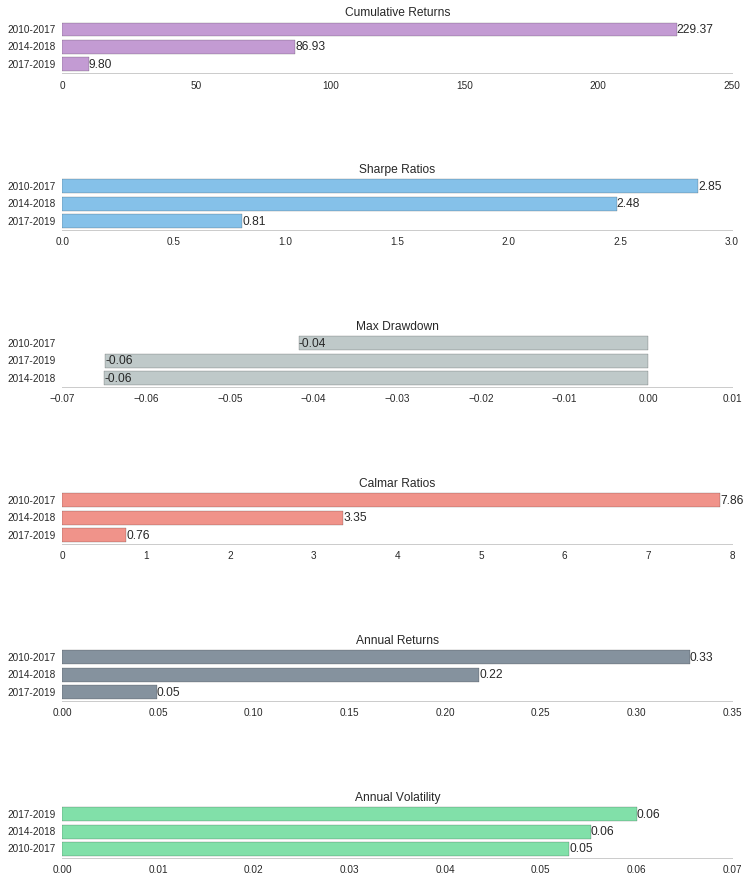

In [6]:
#: Creating the subplots
fig = plt.figure(figsize=(12, 15))
plot_num = 6
col = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
create_plot(total_returns, return_y_pos, return_labels, col[0], "% Return", "Cumulative Returns", 1, plot_num)
create_plot(sharpe_ratios, y_pos, labels, col[1], "Sharpe", "Sharpe Ratios", 2, plot_num)
create_plot(drawdowns, drawdown_y_pos, drawdown_labels, col[2], "% Drawdown", "Max Drawdown", 3, plot_num)
create_plot(calmar_ratios, calmar_y_pos, calmar_labels, col[3], "Calmar", "Calmar Ratios", 4, plot_num)
create_plot(annual_returns, annual_y_pos, annual_labels, col[4], "% Return", "Annual Returns", 5, plot_num)
create_plot(annual_volatility, vol_y_pos, vol_labels, col[5], "% Volatility", "Annual Volatility", 6, plot_num)
fig.subplots_adjust(wspace=.4, hspace=2)
sns.despine(left=True)